In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/sme-invoicing-assistant


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/sme-invoicing-assistant/.env


True

In [4]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("results/gpt-4o-mini-gpt-4o-mini/emails.db")
# conn = sqlite3.connect("src/data/db/llama3.2-vision_11b-qwen2.5_32b/emails.db")

# Write your SQL query
query = "SELECT * FROM emails"

# Read the query results into a pandas DataFrame
df = pd.read_sql(query, conn)

df.head(5)

,email_id,sender_email,recipient_email,subject,email_body,attachments,process_status,response,start_time,end_time,total_time,successful_requests,total_tokens,prompt_tokens,completion_tokens,total_cost
0,93185A89130149C0A842968E4AFDCAA2,RobinLevine@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 43925,Hi Tanya ! Please find attached payment screen...,transaction_1.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-21T21:54:01.661961,2025-01-21T21:54:23.614651,21.9527,8,2894,2596,298,0.0005682
1,614972488B7B411BAEA4814CF066CDAA,StevenNixon@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 51782,Hi Tanya ! Please find attached payment screen...,transaction_2.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-21T21:54:23.616947,2025-01-21T21:54:35.695285,12.0783,28,9996,8948,1048,0.001971
2,C484ABEB38F44D29960B1CEF58510627,MadisonFord@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 42968,Hi Tanya ! Please find attached payment screen...,transaction_3.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-21T21:54:35.696824,2025-01-21T21:54:44.353607,8.6568,60,21313,19060,2253,0.0042108
3,706B3403E8024178948B3BFBF9E64A25,KathrynJones@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 92948,Hi Tanya ! Please find attached payment screen...,transaction_4.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-21T21:54:44.356464,2025-01-21T21:54:55.421207,11.0647,104,36838,32930,3908,0.0072843
4,86838440CA6C472AACFA3FCE1382609C,ChristineOwens@example.com,tanya.official.456@gmail.com,Payment Confirmation for Invoice ID: 20304,Hi Tanya ! Please find attached payment screen...,transaction_5.jpeg,SUCCESS,"{""content"": ""DONE""}",2025-01-21T21:54:55.423148,2025-01-21T21:55:02.572704,7.1496,160,56570,50558,6012,0.0111909


In [5]:
# Code to filter and remove repeated Invoice ID specific data from emails db
error_df = df.loc[df["process_status"] == "ERROR", ["response", "email_id"]]
ground_truth_df = pd.read_csv("./src/data/synthetic_data/ground_truth_data.csv")
ground_truth_df.head()
matching_rows = ground_truth_df[ground_truth_df["email_id"].isin(error_df["email_id"])]
# print(matching_rows)
error_df = error_df.merge(
    matching_rows[["email_id", "invoice_id", "amount"]], on="email_id", how="left"
)
transactions_df = pd.read_csv("./src/data/synthetic_data/transactions.csv")
ground_truth_df = pd.read_csv("./ground_truth_data 2.csv")
duplicate_rows = transactions_df[transactions_df["invoice_id"].duplicated(keep=False)]
# print(duplicate_rows)
num_duplicates = transactions_df["invoice_id"].duplicated().sum()
# print(f"Number of duplicate invoice_ids: {num_duplicates}")
duplicated_invoice_ids = transactions_df[
    transactions_df["invoice_id"].duplicated(keep=False)
]["invoice_id"].unique()
print("Unique duplicated invoice_ids:")
print(duplicated_invoice_ids)
matched_rows_emailid = ground_truth_df[
    ground_truth_df["invoice_id"].isin(duplicated_invoice_ids)
]
email_id_associated_with_duplicated_invoice_id = matched_rows_emailid[
    "email_id"
].tolist()
# print(email_id_associated_with_duplicated_invoice_id)
# print(len(email_id_associated_with_duplicated_invoice_id))

Unique duplicated invoice_ids:
['47535' '83211' '33011' '32831' '78443' 'I20283' 'I17919' 'I19555'
 'I13830' 'I15694' 'I11539' 'I12224' 'I11959' 'I15130' 'I13807' 'I16375'
 'I15190' 'I16935' 'I18364' 'I18536' 'I11126' 'I15903' 'I15165' 'I12970'
 'I15573' 'I14987' 'I13368' 'I20256' 'I17489' 'I12089' 'I19233' 'I14854'
 'I17006' 'I17250' 'I13980' 'I12734' 'I20809' 'I20544' 'I10079' 'I17774'
 'I18754' 'I16990' 'I19919' 'I15684' 'I19904' 'I14215' 'I11364' 'I13212'
 'I13346' 'I15199' 'I16771' 'I16433']


In [6]:
## DF without repeated Invoice ID's
df_filtered = df[~df["email_id"].isin(email_id_associated_with_duplicated_invoice_id)]

In [7]:
print(df_filtered.describe())

                                email_id              sender_email  \
count                               1895                      1895   
unique                              1895                      1883   
top     93185A89130149C0A842968E4AFDCAA2  MichaelJones@example.com   
freq                                   1                         3   

                     recipient_email  \
count                           1895   
unique                             1   
top     tanya.official.456@gmail.com   
freq                            1895   

                                           subject  \
count                                         1895   
unique                                        1895   
top     Payment Confirmation for Invoice ID: 43925   
freq                                             1   

                                               email_body attachments  \
count                                                1895        1895   
unique                         

In [8]:
import matplotlib.pyplot as plt


def plot_value_distribution(df_filtered, col="category", top_n=10):
    df_filtered[col].value_counts()[:top_n].plot(kind="bar")
    plt.title(f"Distribution of {col}")

    # add the count on top of the bars
    for i in range(len(df_filtered[col].value_counts()[:top_n])):
        count = df_filtered[col].value_counts().values[i]
        plt.text(i, count, count, ha="center")

    plt.show()

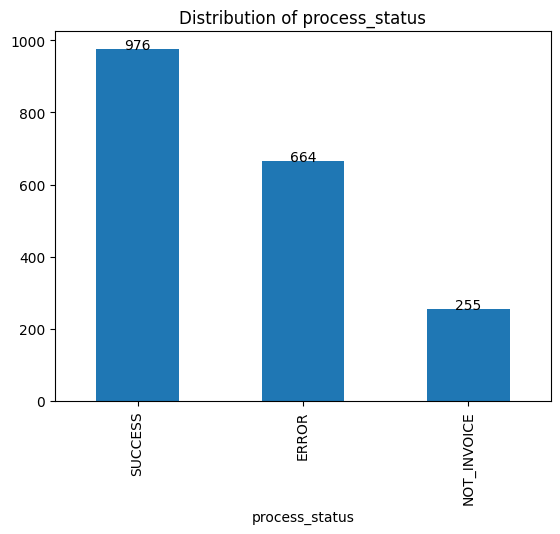

In [9]:
plot_value_distribution(df_filtered, "process_status")

In [10]:
error_df = df_filtered[df_filtered["process_status"] == "ERROR"]

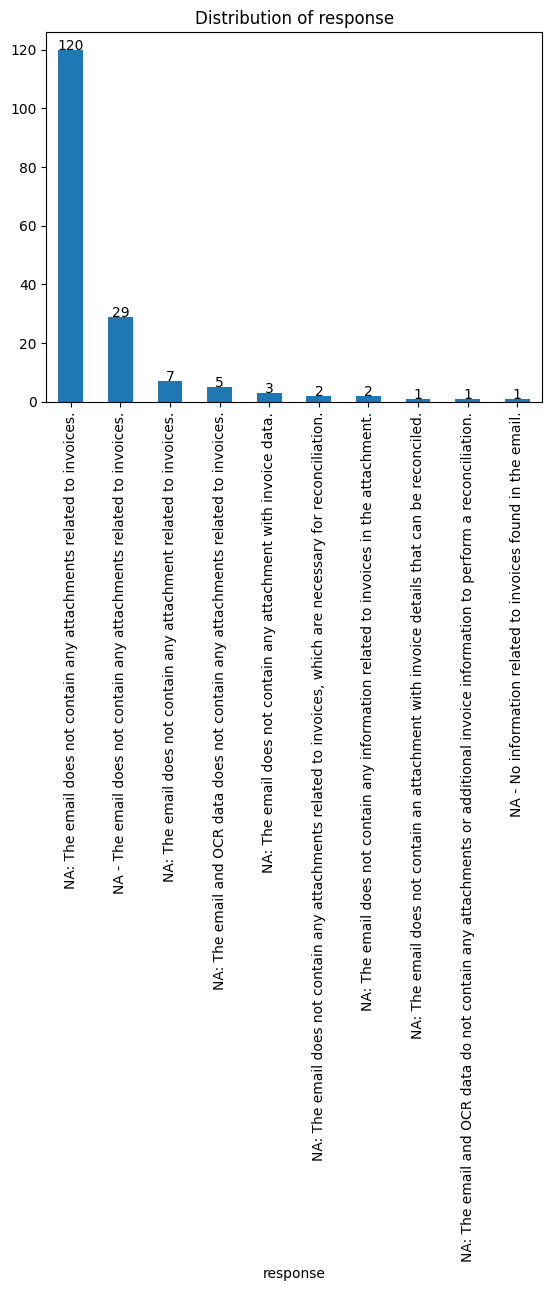

In [11]:
error_df2 = df_filtered[df_filtered["process_status"] == "NOT_INVOICE"]
plot_value_distribution(error_df2, "response")
error_df2.to_csv(
    "results/gpt-4o-mini-gpt-4o-mini/error_analysis_gpt-4o-mini-gpt-4o-mini_additional.csv"
)

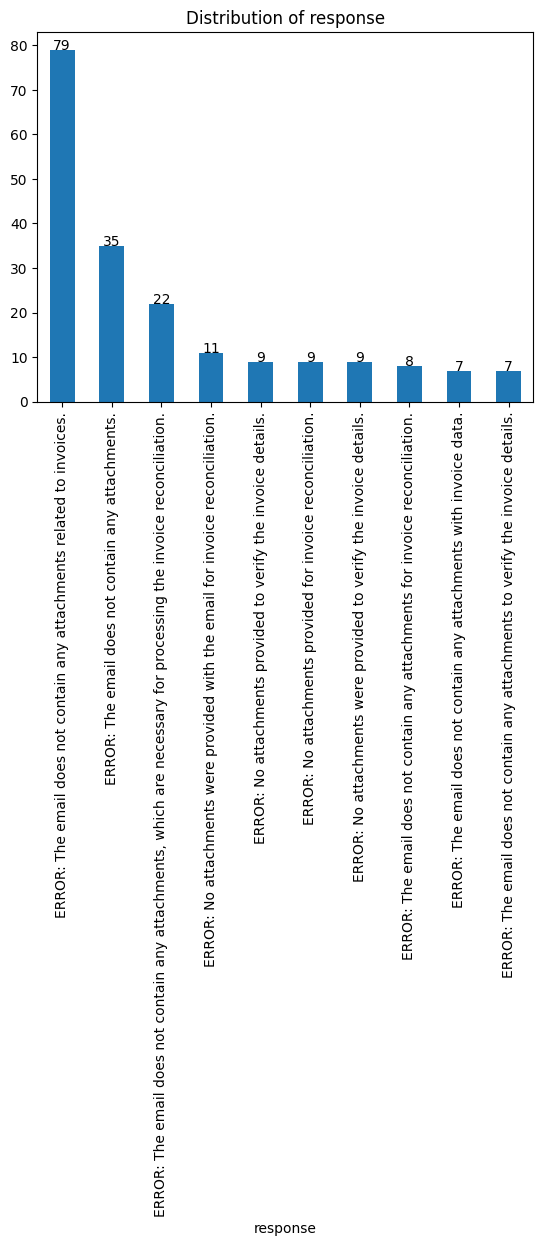

In [12]:
plot_value_distribution(error_df, "response")

In [13]:
error_df.to_csv(
    "results/gpt-4o-mini-gpt-4o-mini/error_analysis_gpt-4o-mini-gpt-4o-mini.csv"
)

In [14]:
df_filtered.columns

Index(['email_id', 'sender_email', 'recipient_email', 'subject', 'email_body',
       'attachments', 'process_status', 'response', 'start_time', 'end_time',
       'total_time', 'successful_requests', 'total_tokens', 'prompt_tokens',
       'completion_tokens', 'total_cost'],
      dtype='object')

In [15]:
df_filtered["end_time"] = pd.to_datetime(df["end_time"])
df_filtered["start_time"] = pd.to_datetime(df["start_time"])
df_filtered["duration"] = (
    df_filtered["end_time"] - df_filtered["start_time"]
).dt.total_seconds()
df_filtered[["duration", "total_time"]].head()

/var/folders/7x/56svhln929zdh2xhr3mwqg4r0000gn/T/ipykernel_52841/781749110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["end_time"] = pd.to_datetime(df["end_time"])
/var/folders/7x/56svhln929zdh2xhr3mwqg4r0000gn/T/ipykernel_52841/781749110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["start_time"] = pd.to_datetime(df["start_time"])
/var/folders/7x/56svhln929zdh2xhr3mwqg4r0000gn/T/ipykernel_52841/781749110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

,duration,total_time
0,21.952690,21.9527
1,12.078338,12.0783
2,8.656783,8.6568
3,11.064743,11.0647
4,7.149556,7.1496


<Axes: ylabel='Frequency'>

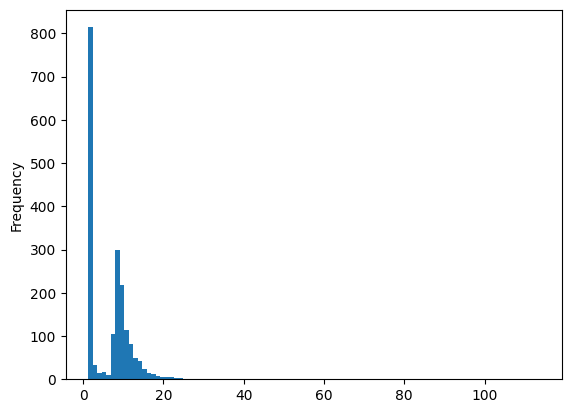

In [16]:
# plot the distribution of duration
df_filtered["duration"].plot(kind="hist", bins=100)

In [17]:
df_filtered["duration"].describe()

count    1895.000000
mean        6.980744
std         8.253466
min         1.281016
25%         1.694999
50%         7.764981
75%         9.696874
max       113.579131
Name: duration, dtype: float64

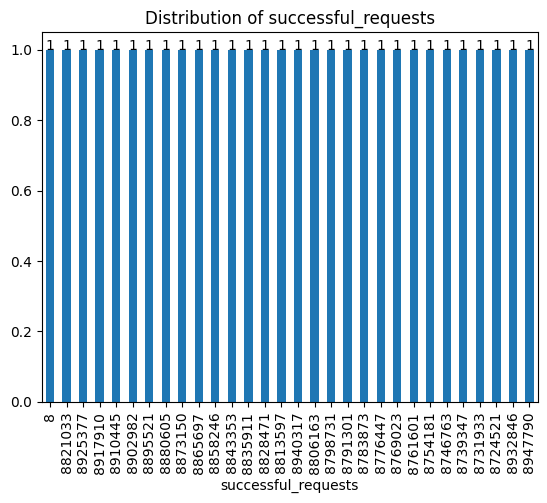

In [18]:
plot_value_distribution(df_filtered, "successful_requests", top_n=30)

In [19]:
df_filtered["process_status"].value_counts()

process_status
SUCCESS        976
ERROR          664
NOT_INVOICE    255
Name: count, dtype: int64

** Success Rate **

In [20]:
success_rate = df_filtered["process_status"].value_counts()["SUCCESS"] / len(
    df_filtered
)
success_rate

0.5150395778364116

** Total Power Consumption in Watt **

In [21]:
def total_power_in_watt(file_path):
    df = pd.read_csv(file_path)
    return df["CPU Package Power [W]"].mean() + df["GPU Power [W]"].mean()


power_idle = total_power_in_watt("results/power_idle.csv")
power_idle

29.873

In [22]:
"""power_with_vision = total_power_in_watt("results/gpt-4o-gpt-4o/power_with_vision.csv")
power_without_vision = total_power_in_watt("results/gpt-4o-gpt-4o/power_without_vision.csv")
power_with_vision, power_without_vision"""

'power_with_vision = total_power_in_watt("results/gpt-4o-gpt-4o/power_with_vision.csv")\npower_without_vision = total_power_in_watt("results/gpt-4o-gpt-4o/power_without_vision.csv")\npower_with_vision, power_without_vision'

** Mean Response Time ***

In [23]:
mean_response_time = df_filtered["duration"].mean()
mean_response_time

6.980743529287599

In [24]:
"""average_energy_consumption = ((power_with_vision + power_without_vision) / 2 - power_idle) * mean_response_time
average_energy_consumption"""

'average_energy_consumption = ((power_with_vision + power_without_vision) / 2 - power_idle) * mean_response_time\naverage_energy_consumption'

In [25]:
df_filtered.describe()

,start_time,end_time,duration
count,1895,1895,1895.000000
mean,2025-01-22 00:25:10.904400128,2025-01-22 00:25:17.885143808,6.980744
min,2025-01-21 21:54:01.661961,2025-01-21 21:54:23.614651,1.281016
25%,2025-01-21 23:24:59.451774720,2025-01-21 23:25:08.111912960,1.694999
50%,2025-01-22 00:57:10.762177024,2025-01-22 00:57:17.791898112,7.764981
75%,2025-01-22 01:23:45.100083968,2025-01-22 01:23:46.678009600,9.696874
max,2025-01-22 01:44:18.186340,2025-01-22 01:44:19.659469,113.579131
std,NaN,NaN,8.253466


In [26]:
row = df_filtered[df_filtered["process_status"] == "NOT_INVOICE"].iloc[0]
row

email_id                                0454744041EF4749820C47DDF7CCC6A8
sender_email                                    BradThompson@example.com
recipient_email                             tanya.official.456@gmail.com
subject                       Payment Confirmation for Invoice ID: 95153
email_body             Hi Tanya ! Please find attached payment screen...
attachments                                         transaction_623.jpeg
process_status                                               NOT_INVOICE
response               NA: The email and OCR data do not contain any ...
start_time                                    2025-01-21 23:51:14.084325
end_time                                      2025-01-21 23:52:47.631053
total_time                                                       93.5467
successful_requests                                              2573791
total_tokens                                                  1107191051
prompt_tokens                                      

*** Observations ***
1. Total 976 cases were successfull 
2. Total 664 Error Cases Found : The Errors were related to LLM hallucination ,OCR tool not working and DB locking 
3. All 255 cased related process state - 'NOT_INVOICE',indiacted unsuccesfull OCR/Email extraction job by LLM (check results/gpt-4o-gpt-4o/error_analysis_gpt-4o-gpt-4o_additional.csv)
4. There is no 'Power with Vision and Without Vision data available for this.






In [29]:
df_filtered.columns

Index(['email_id', 'sender_email', 'recipient_email', 'subject', 'email_body',
       'attachments', 'process_status', 'response', 'start_time', 'end_time',
       'total_time', 'successful_requests', 'total_tokens', 'prompt_tokens',
       'completion_tokens', 'total_cost', 'duration'],
      dtype='object')

In [31]:
df_without_vision = df_filtered[df_filtered["attachments"] == ""]
df_without_vision_success = df_without_vision[
    df_without_vision["process_status"] == "SUCCESS"
]
df_without_vision_success.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1008 to 1973
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   email_id             9 non-null      object        
 1   sender_email         9 non-null      object        
 2   recipient_email      9 non-null      object        
 3   subject              9 non-null      object        
 4   email_body           9 non-null      object        
 5   attachments          9 non-null      object        
 6   process_status       9 non-null      object        
 7   response             9 non-null      object        
 8   start_time           9 non-null      datetime64[ns]
 9   end_time             9 non-null      datetime64[ns]
 10  total_time           9 non-null      object        
 11  successful_requests  9 non-null      object        
 12  total_tokens         9 non-null      object        
 13  prompt_tokens        9 non-null      o

In [36]:
from src.misc.metrics import print_row_details


print_row_details(df_without_vision_success, range(len(df_without_vision_success)))

--------------------------------------------------
email_id: 146df523-d27f-4824-9216-64f5bec838aa
--------------------------------------------------
sender_email: annemathis@example.org
--------------------------------------------------
recipient_email: tanya.official.456@gmail.com
--------------------------------------------------
subject: Payment Confirmation for Invoice I16487
--------------------------------------------------
email_body: Subject: Payment Confirmation for Invoice I16487
                Kimberly Ashley <annemathis@example.org>
                Wed, Jan 01, 2025, 03:52 PM
                Dear Tanya, I hope this message finds you well.I am writing to confirm that we have successfully made the payment for Invoice I16487, related to our recent order with you. Here are the details:  
                Description:
                Invoice Date: December 19, 2024
                Item: Co-ord sets Men
                Quantity: 5
                Subtotal: $343.62
               

In [37]:
df_without_vision_failure = df_without_vision[
    df_without_vision["process_status"] != "SUCCESS"
]
df_without_vision_failure.info()

<class 'pandas.core.frame.DataFrame'>
Index: 896 entries, 1000 to 1999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   email_id             896 non-null    object        
 1   sender_email         896 non-null    object        
 2   recipient_email      896 non-null    object        
 3   subject              896 non-null    object        
 4   email_body           896 non-null    object        
 5   attachments          896 non-null    object        
 6   process_status       896 non-null    object        
 7   response             896 non-null    object        
 8   start_time           896 non-null    datetime64[ns]
 9   end_time             896 non-null    datetime64[ns]
 10  total_time           896 non-null    object        
 11  successful_requests  896 non-null    object        
 12  total_tokens         896 non-null    object        
 13  prompt_tokens        896 non-null   

In [38]:
print_row_details(df_without_vision_failure, range(5))

--------------------------------------------------
email_id: 2afa6f82-36dc-4b92-a725-c9c16e959258
--------------------------------------------------
sender_email: kevinfoster@example.com
--------------------------------------------------
recipient_email: tanya.official.456@gmail.com
--------------------------------------------------
subject: Payment Confirmation for Invoice I14982
--------------------------------------------------
email_body: Subject: Payment Confirmation for Invoice I14982
                John Lee <kevinfoster@example.com>
                Sun, Jan 05, 2025, 10:04 AM
                Dear Tanya, I hope this message finds you well.I am writing to confirm that we have successfully made the payment for Invoice I14982, related to our recent order with you. Here are the details:  
                Description:
                Invoice Date: December 21, 2024
                Item: Office Wear Suits
                Quantity: 2
                Subtotal: $372.31
                Ta